# ABS Inflation multi-measure

## Python set-up

In [1]:
# system imports
from typing import Callable, Sequence, cast, NamedTuple
from functools import cache

# analytic imports
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import readabs as ra
from readabs import metacol as mc
import mgplot as mg

# local imports
from abs_helper import ANNUAL_CPI_TARGET_RANGE

In [2]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# save charts in this notebook
CHART_DIR = "./CHARTS/Inflation/"
mg.set_chart_dir(CHART_DIR)
mg.clear_chart_dir()

# some plotting constants
LFOOTER = "Australia. Orig = Original series. SA = Seasonally adjusted series. "
YEARLY_RANGE = {"axhspan": ANNUAL_CPI_TARGET_RANGE}

# display charts in this notebook
SHOW = True

## NEW -- with a different data capture mechanism

### Typing and mapping structures

In [3]:
type EntryTuple = tuple[str, str, str, str, str]

In [4]:
stype_codes = {
    "O": "Original",
    "S": "Seasonally Adjusted",
    "SA": "Seasonally Adjusted",
    "T": "Trend",
}

In [5]:
OLD_CPI_FILE = "./ABS-Data/Qrtly-CPI-Time-series-spreadsheets-all.zip"
COLOURS = [
    # 10 relatively distinct colours
    'tab:blue',
    'tab:orange', 
    'tab:green',
    'tab:red',
    'tab:purple',
    'tab:brown',
    'tab:pink',
    'tab:gray',
    'tab:olive',
    'tab:cyan',
]

### Desired data sets

In [6]:
W_CPI_ONLY_MEASURES: dict[str, EntryTuple] = {
    # name: (cat, table, did, stype, unit)
    # --- the next four will need to be updated when new Qrtly CPI data is available ---
    "Qrtly Headline CPI (Orig)" :
        ("", "640106", "All groups CPI ;", "O", ""),
    "Qrtly Headline CPI (SA)" :
        ("", "640106", "All groups CPI, seasonally adjusted", "S", ""),
    "Qrtly Trimmed Mean CPI (SA)" :
        ("", "640106", "Trimmed Mean", "S", ""),
    "Qrtly Weighted Median CPI (SA)" :
        ("", "640106", "Weighted Median", "S", ""),
    # --- the next four are the new monthly CPI measures ---
    "Monthly Headline CPI (Orig)" :
        ("6401.0", "640106", "All groups CPI ;", "O", ""),
    "Monthly Headline CPI (SA)" :
        ("6401.0", "640106", "All groups CPI, seasonally adjusted", "S", ""),
    "Monthly Trimmed Mean CPI (SA)" :
        ("6401.0", "640106", "Trimmed Mean", "S", ""),
    "Monthly Weighted Median CPI (SA)" :
        ("6401.0", "640106", "Weighted Median", "S", ""),
}

W_MULTI_MEASURE = {
    # --- the first three will need to be updated when new Qrtly CPI data is available ---
    "Qrtly Headline CPI (SA)" :
        ("", "640106", "All groups CPI, seasonally adjusted", "S", ""),
    "Qrtly Trimmed Mean CPI (SA)" :
        ("", "640106", "Trimmed Mean", "S", ""),
    "Qrtly Weighted Median CPI (SA)" :
        ("", "640106", "Weighted Median", "S", ""),
    # --- the remaining measures should be okay ---
    "Monthly Headline CPI (SA)" :
        ("6401.0", "640106", "All groups CPI, seasonally adjusted", "S", ""),
    "Monthly Trimmed Mean CPI (SA)" :
        ("6401.0", "640106", "Trimmed Mean", "S", ""),
    "Monthly Weighted Median CPI (SA)" :
        ("6401.0", "640106", "Weighted Median", "S", ""),
    "Producer Price Index (Orig)": 
        ("6427.0", "642701", "Final ;  Total (Source) ;", "O", ""),
    "Wage Price Index (All sectors) (SA)": 
        (
            "6345.0", 
            "634501", 
            "Total hourly rates of pay excluding bonuses ;  Private and Public ;  All industries ;", 
            "S", 
            ""
        ),
    "Households implicit price deflator (SA)": 
        (
            "5206.0", 
            "5206005_Expenditure_Implicit_Price_Deflators",
            "Households ;  Final consumption expenditure ;",
            "S",
            "Index"
        ), 
    "GNE implicit price deflator (SA)": 
        (
            "5206.0", 
            "5206005_Expenditure_Implicit_Price_Deflators",
            "Gross national expenditure ;",
            "S",
            "Index"
        ), 
}


W_PHILLIPS = {
    # --- tthe first one will need to be updated when new Qrtly CPI data is available ---
    "Qrtly Trimmed Mean CPI (SA)" :
        ("", "640106", "Trimmed Mean", "S", ""),
    # --- the remaining measures should be okay ---
    "Households implicit price deflator (SA)": 
        (
            "5206.0", 
            "5206005_Expenditure_Implicit_Price_Deflators",
            "Households ;  Final consumption expenditure ;",
            "S",
            "Index"
        ), 
    "Unemployment rate monthly (SA)":
        ("6202.0", "6202001", "Unemployment rate ;  Persons ;", "S", ""),
}

### Data Capture

In [7]:
# This is a fudge, because the new quarterly data will not be available until
# late January 2026 - so we get the old data from a local zip file.

@cache
def get_zip_table(zip_file: str, table: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Get a table from a ABS zip file.

    Args:
        zip_path (str): Path to the ABS zip file.
        table (str): Table identifier.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: data and metadata DataFrames.
    """
    dictionary, meta= ra.read_abs_cat(cat="", zip_file=zip_file, single_excel_only=table)
    data = dictionary[table]
    meta = meta[meta[mc.table] == table]
    return data, meta

In [8]:
@cache
def get_table(cat, table) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Get ABS data table and metadata for a given ABS catalogue-id and table-id."""

    dictionary, meta = ra.read_abs_cat(cat, single_excel_only=table)
    data = dictionary[table]
    return data, meta

In [9]:
@cache
def load_series(input_tuple: EntryTuple) -> Series:
    """Load ABS annual growth series return as a Series.
       Note: if "index" in unit, then convert to annual growth.
       Returns: a pandas Series."""
    
    cat, table, did, stype, unit = input_tuple
    stype = stype if stype not in stype_codes else stype_codes[stype]

    # Fudge to use old CPI data until new data is available
    if cat:
        data, meta = get_table(cat, table)
    else:                                               # These two lines are part of the fudge
        data, meta = get_zip_table(OLD_CPI_FILE, table) #

    selector = {
        did: mc.did,
        stype: mc.stype,
    }
    if unit:
        selector[unit] = mc.unit
    if "index" not in unit.lower() and "rate " not in did.lower(): # 'rate ' because 'rates' in WPI
        # ABS inconsistent capitalisation ...
        selector["Percentage"] = mc.did
        selector["revious"] = mc.did
        selector["ear"]= mc.did
    table, series_id, units = ra.find_abs_id(meta, selector, verbose=False)
    series = data[series_id]
    if "index" in units.lower():
        p_map = {"Q": 4, "M": 12}
        series = series.pct_change(periods=p_map.get(series.index.freqstr[0], 1)) * 100.0

    return series


In [10]:
def get_abs_data(wanted: dict[str, EntryTuple]) -> dict[str, Series]:
    """Load annual ABS inflation data series."""

    box = {}
    for (w, t) in wanted.items():
        series = load_series(t)
        box[w] = series

    return box

## Plotting

### Chart the key CPI measures

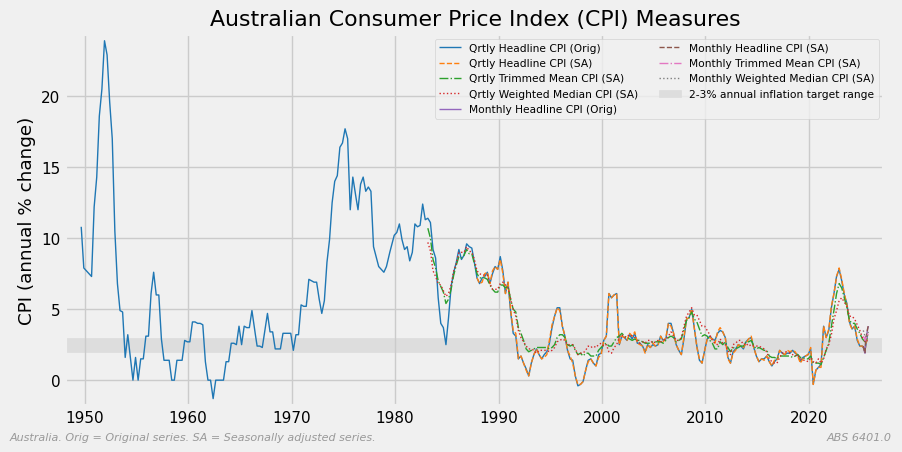

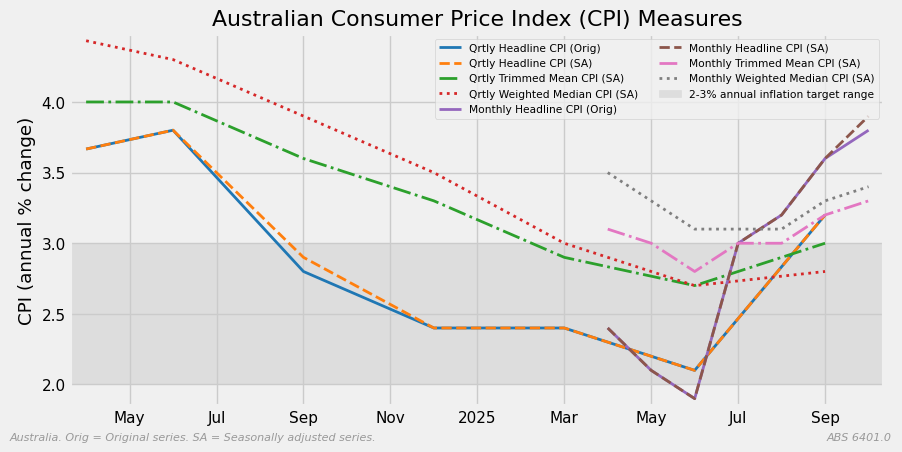

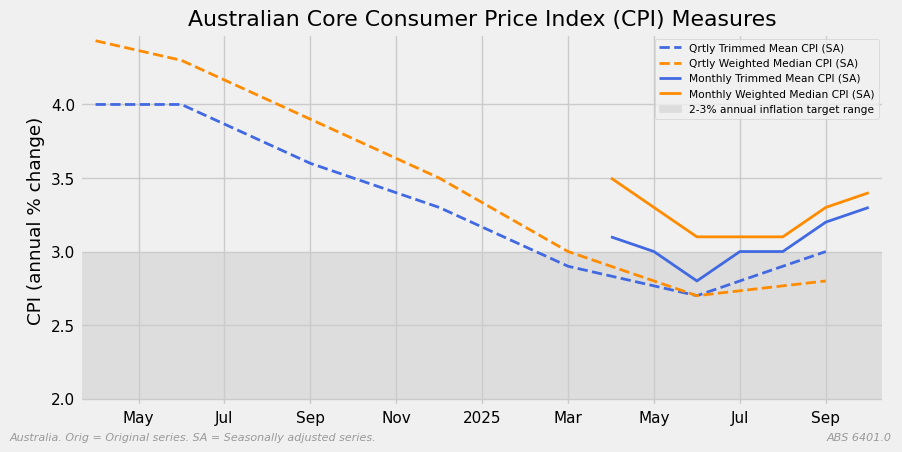

In [11]:
def cpi_multi_chart():
    """Plot multi-measure CPI chart."""

    # this will need to be updated when new quarterly data is available
    combined = get_abs_data(W_CPI_ONLY_MEASURES)

    to_drop = []
    for label, series in combined.items():
        # identify headline CPI - so we can produce a core only chart later
        if "Headline CPI" in label:
            to_drop.append(label)
        # convert quarterly series to monthly
        if series.index.freqstr[0] == "Q":
            combined[label] = ra.qtly_to_monthly(series)

    # convert to a dataframe and plot
    frame = pd.DataFrame(combined)
    mg.multi_start(
        starts=[0,-19],
        function=mg.line_plot_finalise,
        data=frame,
        title="Australian Consumer Price Index (CPI) Measures",
        ylabel="CPI (annual % change)",
        **YEARLY_RANGE,
        legend={"loc": "best", "ncol": 2, "fontsize": "x-small"},
        lfooter=LFOOTER,
        color=COLOURS,
        rfooter="ABS 6401.0",
        show=SHOW
    )

    # remove the headline CPIs and re-plot for core CPI only
    frame = frame.drop(columns=to_drop)
    mg.line_plot_finalise(
        data=frame.iloc[-19:],
        title="Australian Core Consumer Price Index (CPI) Measures",
        ylabel="CPI (annual % change)",
        **YEARLY_RANGE,
        lfooter=LFOOTER,
        style=["--", "--", "-", "-", ],
        color = ["royalblue", "darkorange", "royalblue", "darkorange"],
        rfooter="ABS 6401.0",
        show=SHOW
    )


cpi_multi_chart()

### Chart a selection of ABS inflation measures

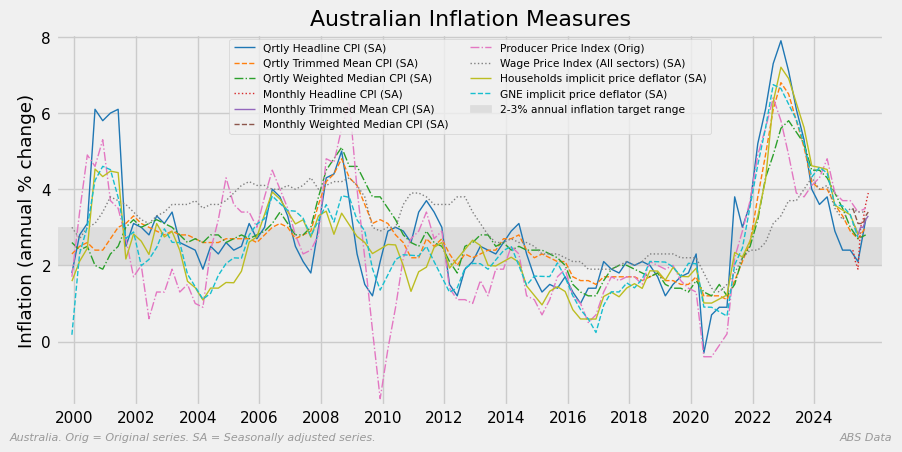

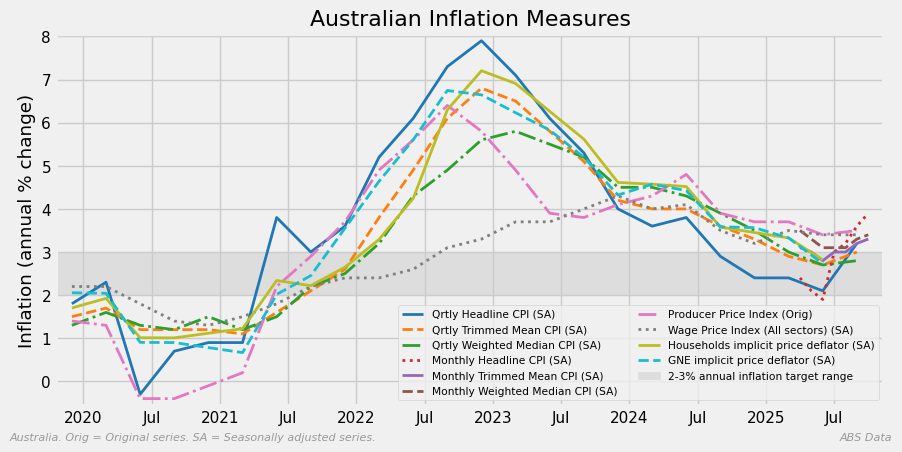

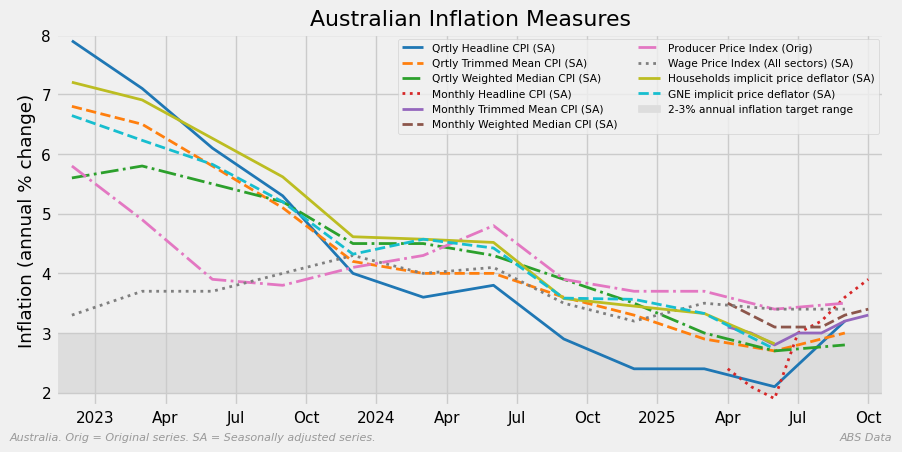

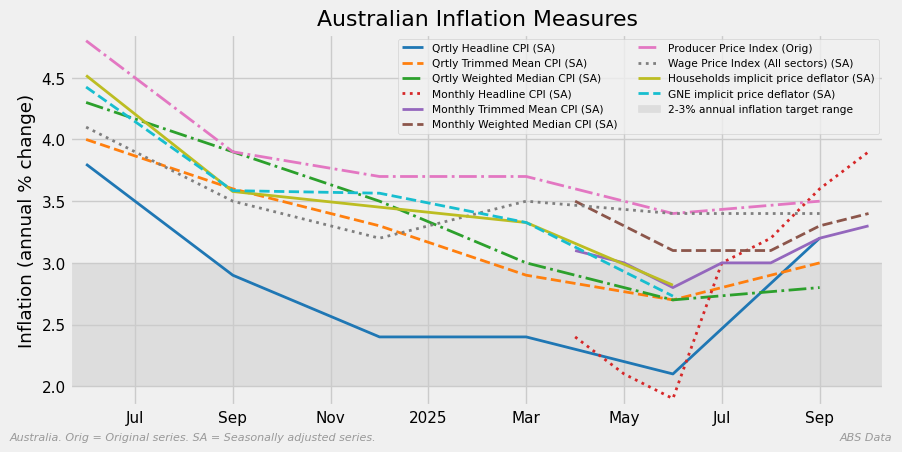

In [12]:
def multi_measure_plot() -> None:
    combined = get_abs_data(W_MULTI_MEASURE)

    for label, series in combined.items():
        # convert quarterly series to monthly
        if series.index.freqstr[0] == "Q":
            combined[label] = ra.qtly_to_monthly(series)

    # Plot
    frame = pd.DataFrame(combined)
    mg.multi_start(
        starts=[pd.Period("1999-12"), pd.Period("2019-12"), pd.Period("2022-12"), pd.Period("2024-06")],
        function=mg.line_plot_finalise,
        data=frame,
        title="Australian Inflation Measures",
        ylabel="Inflation (annual % change)",
        **YEARLY_RANGE,
        legend={"loc": "best", "ncol": 2, "fontsize": "x-small"},
        lfooter=LFOOTER,
        rfooter="ABS Data",
        color=COLOURS,
        show=SHOW
    )


multi_measure_plot()

### Phillips Curves

In [13]:
def xy_plot(
    frame: DataFrame,
    line_label: str,
    point_labels: Sequence[int] | None = None,
    ax = None,
    **kwargs,
) -> Axes:
    """ "Plot and label the heart of the curve.

    Arguments:
    frame is a two column DataFrame, first col is x vales, 2nd col is y values.
    line_label is the label for the line.
    point_labels is the points to label.

    Returns:
    An Axes object."""

    width = kwargs.pop("width", 2)
    color = kwargs.pop("color", "royalblue")
    
    ax = frame.plot(
        x=frame.columns[0],
        y=frame.columns[1],
        lw=width,
        color=color,
        label=line_label if line_label else "_nolegend_",
        ax=ax,
    )
    point_labels = [] if point_labels is None else point_labels
    for n in point_labels:
        # Label the start and end
        ax.text(
            frame[frame.columns[0]].iloc[n],
            frame[frame.columns[1]].iloc[n],
            f"{frame.index[n]} ",
            fontsize="x-small",
            ha="right",
        )
    return ax

In [14]:
def add_regression(
    ax,
    frame: DataFrame,
    line_label: str,
    **kwargs: int | str,
) -> None:
    """Fit a polynomial regression line to the data."""

    color: str = str(kwargs.get("color", "darkred"))
    degree: int = int(kwargs.get("degree", 1))
    linestyle: str = str(kwargs.get("linestyle", "--"))
    width: float = float(kwargs.get("width", 0.75))

    model = np.poly1d(
        np.polyfit(frame[frame.columns[0]], frame[frame.columns[1]], degree)
    )
    polyline = np.linspace(
        frame[frame.columns[0]].min(), frame[frame.columns[0]].max(), 50
    )
    ax.plot(
        polyline,
        model(polyline),
        color=color,
        linestyle=linestyle,
        lw=width,
        label=line_label if line_label else "_nolegend_",
    )

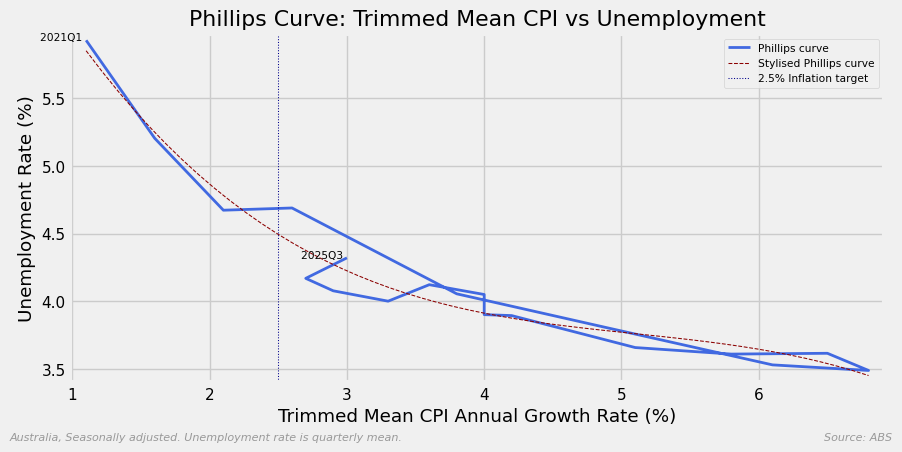

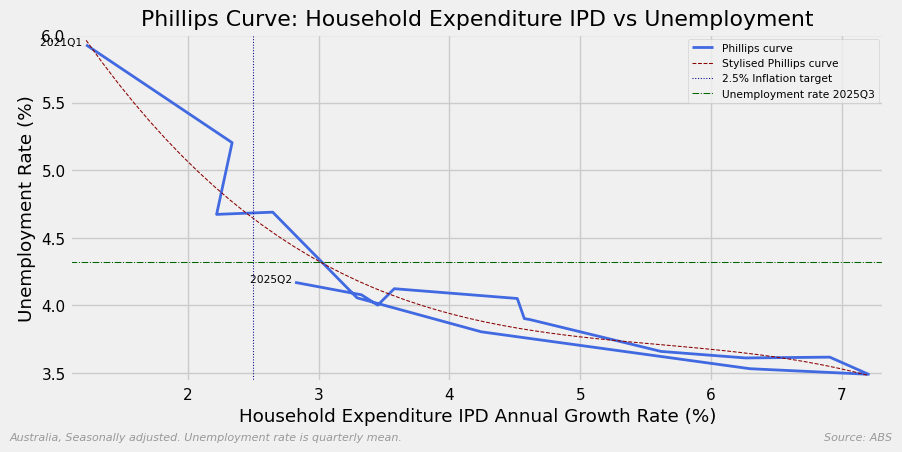

In [15]:
def phillips_curve() -> None:
    """Produce a Phillips Curve chart."""

    # --- Organise the data
    data = get_abs_data(W_PHILLIPS)
    ue_rate = ra.monthly_to_qtly(data["Unemployment rate monthly (SA)"])
    hheipd = data["Households implicit price deflator (SA)"]
    tm_cpi = data["Qrtly Trimmed Mean CPI (SA)"]

    inflation = {
        "Trimmed Mean CPI": tm_cpi,
        "Household Expenditure IPD": hheipd,
    }

    start = "2021Q1"  # "2009Q4"  #
    for label, series in inflation.items():

        frame = pd.DataFrame({label: series, "_Unemployment Rate": ue_rate})
        last: float = (
            cast(float, frame.iloc[-1, 1]) if frame.iloc[-1].isna().any() else 0.0
        )
        last_date = frame.index[-1]
        frame = frame.loc[
            lambda x: x.index >= start
        ].dropna()  # drop the last row if it has a NaN

        # --- Plot the data
        ax = xy_plot(frame, "Phillips curve", point_labels=(0, -1))
        add_regression(ax, frame, "Stylised Phillips curve", degree=3)

        ax.axvline(
            2.5, color="darkblue", linestyle=":", lw=0.75, label="2.5% Inflation target"
        )
        if last > 0.0:
            ax.axhline(
                last,
                color="darkgreen",
                linestyle="-.",
                lw=0.75,
                label=f"Unemployment rate {last_date}",
            )
        mg.finalise_plot(
            ax,
            title=f"Phillips Curve: {label} vs Unemployment",
            ylabel="Unemployment Rate (%)",
            xlabel=f"{label} Annual Growth Rate (%)",
            lfooter="Australia, Seasonally adjusted. Unemployment rate is quarterly mean. ",
            rfooter="Source: ABS",
            legend=True,
            show=SHOW,
        )


phillips_curve()

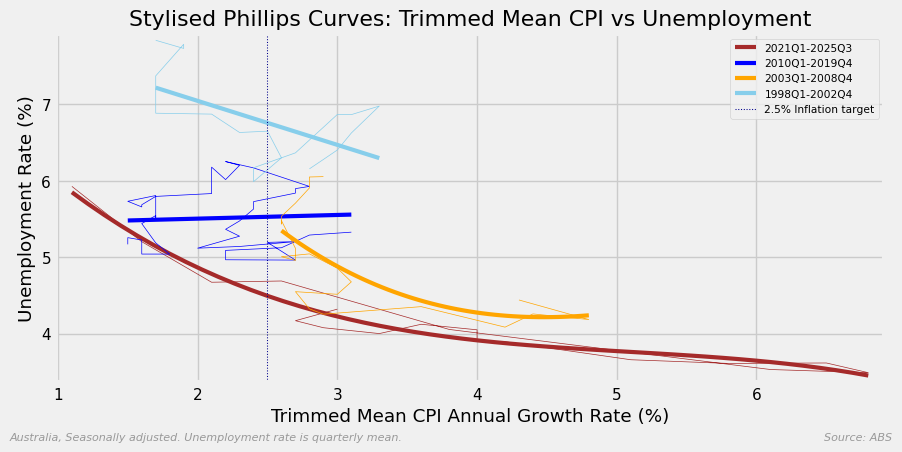

In [16]:
def stylised_phillips():
    """Produce a Stylised Phillips Curve chart for different periods."""
    
    # --- Organise the data
    data = get_abs_data(W_PHILLIPS)
    ue_rate = ra.monthly_to_qtly(data["Unemployment rate monthly (SA)"])
    tm_cpi = data["Qrtly Trimmed Mean CPI (SA)"]

    # --- Define the periods to plot
    period_sets = [
        [
            list(pd.period_range(pd.Period("2021Q1", freq="Q"), tm_cpi.index[-1])),
            "brown",
            3,
        ],
        [
            list(pd.period_range(pd.Period("2010Q1", freq="Q"), pd.Period("2019Q4", freq="Q"))),
            "blue",
            1,
        ],
        [
            list(pd.period_range(pd.Period("2003Q1", freq="Q"), pd.Period("2008Q4", freq="Q"))),
            "orange",
            3,
        ],
        [
            list(pd.period_range(pd.Period("1998Q1", freq="Q"), pd.Period("2002Q4", freq="Q"))),
            "skyblue",
            1,
        ],
    ]
    
    _, ax = plt.subplots()
    
    for start_stop, color, degree in period_sets:
        assert len(start_stop) >= 2, f"start_stop len={len(start_stop)} must have start and end"
        label = f"{start_stop[0]}-{start_stop[-1]}"
        
        frame = pd.DataFrame({
            "Trimmed Mean CPI": tm_cpi,
            "Unemployment Rate": ue_rate,
        })
        frame = frame.loc[start_stop[0]:start_stop[-1]].dropna()

        xy_plot(
            frame,
            line_label="",
            point_labels=[],
            ax=ax,
            width=0.5,
            color=color,
        )
        
        add_regression(
            ax,
            frame,
            label,
            degree=degree,
            color=color,
            linestyle="-",
            width=3,
        )

    axvline = {
        "x": 2.5,
        "color": "darkblue",
        "linestyle": ":",
        "lw": 0.75,
        "label": "2.5% Inflation target",
    }
    
    mg.finalise_plot(
        ax,
        title="Stylised Phillips Curves: Trimmed Mean CPI vs Unemployment",
        ylabel="Unemployment Rate (%)",
        xlabel="Trimmed Mean CPI Annual Growth Rate (%)",
        lfooter="Australia, Seasonally adjusted. Unemployment rate is quarterly mean.",
        rfooter="Source: ABS",
        axvline=axvline,
        legend=True,
        show=SHOW,
    )


stylised_phillips()

## Finished

In [17]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-11-27 15:02:12

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.7.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

mgplot    : 0.2.12
matplotlib: 3.10.7
numpy     : 2.3.5
readabs   : 0.1.6
typing    : 3.10.0.0
pandas    : 2.3.3

Watermark: 2.5.0



In [18]:
print("End of Inflatioin Analysis")

End of Inflatioin Analysis


## OLD -- What we did previously -- dead code

In [19]:
# Everything below here has not been updated yet
assert False

AssertionError: 

## Beveridge curve

In [ ]:
def beveridge_curve() -> None:
    """Plot a Beveridge curve."""

    # --- Collect data for the next chart
    lfs, _ = ra.read_abs_series(
        "6202.0", ["A84423043C", "A84423047L"], single_excel_only="6202001"
    )
    ue_rate_q = ra.monthly_to_qtly(
        100 - (lfs["A84423043C"] / lfs["A84423047L"] * 100), q_ending="NOV"
    )
    la, _ = ra.read_abs_series("6354.0", "A590698F", single_excel_only="6354001")
    vr = la["A590698F"] / ra.monthly_to_qtly(lfs["A84423047L"], q_ending="NOV") * 100
    frame = pd.DataFrame({"Unemployment Rate": ue_rate_q, "Job Vacancy Rate": vr})
    start = "2010Q2"
    frame = frame.loc[lambda x: x.index >= start].dropna()

    # --- Plot the next chart
    labels = [0, -1, -5, -9, -13, -17]  # Will need to update from time to time
    ax = xy_plot(frame, "Beveridge curve", point_labels=labels)
    points = frame.loc[lambda x: x.index < "2020Q2"].index.union(
        frame.loc[lambda x: x.index >= "2022Q4"].index
    )
    f = frame.loc[points]
    add_regression(ax, f, "Pre-COVID Beveridge curve (stylised)", degree=2)
    points = frame.loc[lambda x: (x.index >= "2020Q3") & (x.index <= "2022Q2")].index
    f = frame.loc[points]
    add_regression(
        ax,
        f,
        "Post-COVID Beveridge curve (stylised)",
        degree=2,
        color="darkgreen",
        linestyle="-.",
    )
    mg.finalise_plot(
        ax,
        title="Beveridge Curve: Unemployment Rate vs Job Vacancy Rate",
        ylabel="Job Vacancy Rate (%)",
        xlabel="Unemployment Rate (%)",
        lfooter="Australia, Seasonally adjusted. Unemployment rate is quarterly mean "
        + "(quarters ending Feb, May, Aug, Nov).",
        rfooter="Source: ABS 6202.0, 6354.0",
        legend=True,
        show=SHOW,
    )


beveridge_curve()

### Okun's curve

Note: this is a faily weak relationship

In [ ]:
def okun():
    """Plot Okun's curve."""

    # seasonally adjusted unemployment rate - post 1978
    lfs, _ = ra.read_abs_series(
        "6202.0", ["A84423043C", "A84423047L"], single_excel_only="6202001"
    )
    ue_rate = ra.monthly_to_qtly(100 - (lfs["A84423043C"] / lfs["A84423047L"] * 100))

    # get historic unemployment - quarterly data
    old, _old_meta = ra.read_abs_series(
        cat="1364.0.15.003", series_id=["A2454521V", "A2454517C"]
    )
    uemployed, labour_force = old["A2454521V"], old["A2454517C"]
    ue_hist = ((uemployed / labour_force) * 100).dropna()

    # combine into a single quarterly unemployment rate series
    u = (
        ue_rate.reindex(
            pd.period_range(start=ue_hist.index.min(), end=ue_rate.index.max())
        )
        .sort_index()
        .pipe(lambda x: x.where(x.notnull(), ue_hist))
    )

    # GDP growth rate - seasonally adjusted chain volume measure percentage change
    na, _ = ra.read_abs_series(
        "5206.0", "A2304402X", single_excel_only="5206001_Key_Aggregates"
    )
    gdp = na["A2304402X"]
    for n, n_desc in zip((1, 4), ("Q/Q", "Y/Y")):
        du = u.diff(n).dropna()

        d_gdp = gdp.pct_change(n) * 100

        # join the two series and plot
        x, y = f"Change Unemployment Rate {n_desc}", f"GDP Growth Rate {n_desc}"
        data = pd.DataFrame({x: du, y: d_gdp}).dropna()
        ax = data.plot.scatter(x=x, y=y, s=10, alpha=0.5)

        m, b = np.polyfit(data[x].to_numpy(), data[y].to_numpy(), 1)
        xx = np.linspace(data[x].min(), data[x].max(), 2)
        yy = m * xx + b
        ax.plot(xx, yy, color="red", lw=2, label=f"Regression line (m={m:0.2f})")

        colors = [
            "grey",
            "darkorange",
            "darkorchid",
            "maroon",
            "navy",
            "green",
            "hotpink",
        ]
        styles = ["--", "-.", ":"] * 3
        for i, decade in enumerate(range(1960, 2030, 10)):
            subset = data[data.index.year // 10 == decade // 10]
            m, b = np.polyfit(subset[x].to_numpy(), subset[y].to_numpy(), 1)
            xx = np.linspace(subset[x].min(), subset[x].max(), 2)
            yy = m * xx + b
            ax.plot(
                xx,
                yy,
                color=colors[i],
                ls=styles[i],
                lw=1.5,
                label=f"Regression line for {decade}s (m={m:0.2f})",
            )

        mg.finalise_plot(
            ax,
            title=f"Okun Curve: Change in Unemployment Rate vs GDP Growth {n_desc}",
            ylabel=y + " (%)",
            xlabel=x + " (pp)",
            lfooter="Australia. Unemployment rate is quarterly mean. "
            + "In the legend, m is the slope of the regression line.",
            rfooter="ABS: 6202.0, 5206.0, 1364.0.15.003",
            legend={
                "loc": "best",
                "fontsize": "x-small",
                "ncol": 2,
            },
            x0=True,
            y0=True,
            show=SHOW,
        )

        if n == 1:
            # quarterly data is just too noisy to be useful
            continue

        # recent data
        recent_date = "2021Q3"
        recent_data = data[recent_date:]
        ax = xy_plot(
            recent_data,
            "Okun Curve",
            point_labels=(0, -1),
        )
        add_regression(
            ax,
            recent_data,
            "Post-COVID Okun curve (stylised)",
            degree=1,
            color="darkgreen",
            linestyle="-.",
        )

        mg.finalise_plot(
            ax,
            title=f"{n_desc} Okun Curve: since {recent_date}",
            ylabel=y + " (%)",
            xlabel=x + " (pp)",
            lfooter="Australia. Unemployment rate is quarterly mean. ",
            rfooter="ABS: 6202.0, 5206.0",
            legend=True,
            x0=True,
            y0=True,
            show=SHOW,
        )


okun()

### WPI - CPI Q

In [ ]:
def cpi_v_wpi() -> None:
    """Compare WPI with the CPI."""

    wanted = {
        # the Actual index
        "A3604506F": ("6401.0", "640106", "Consumer Price Index (SA)"),
        "A2713849C": (
            "6345.0",
            "634501",
            "Wage Price Index (All sectors) (SA)",
        ),
    }
    base = "2019Q4"
    frame = pd.DataFrame()
    cats = []
    for series_id, (category_id, seo, title) in wanted.items():
        cats.append(category_id)
        d, _m = ra.read_abs_series(category_id, series_id, single_excel_only=seo)
        series = d[series_id]
        series = series / series.loc[base] * 100
        frame[title] = series[base:]  # type: ignore[misc]
        mg.line_plot_finalise(
            frame,
            title="Inflation and Wages",
            ylabel="Index (2019Q4=100)",
            lfooter=f"{LFOOTER}Quarterly data. ",
            rfooter=f"ABS {', '.join(cats)}",
            legend=True,
            width=2,
            show=SHOW,
        )


cpi_v_wpi()

In [ ]:
print("Finished")